In [1]:
import math
import re
import numpy as np
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [5]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [6]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges/notebooks'

In [7]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges


In [8]:
import sys
sys.path.append('src')
import ouraws

In [9]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="swarthmore"
SUBJECT="opinions"
START_YEAR=2005
FINAL_YEAR=2022

In [10]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [11]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [12]:
len(diversity_words)

15

In [13]:
[(w) for w in diversity_words]

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [14]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [15]:
diversity_pattern = "|".join(diversity_lemmas)

In [16]:
diversity_pattern

'diversity|equity|inclusion|inclusive|inclusivity|equality|equal opportunity|social justice|racial justice|multi-cultural|multicultural|intercultural|intersectional|intersectionality|anti-discrimination'

In [17]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

In [18]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    return text_series, total_diversity_words

In [19]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges'

In [20]:
S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [21]:
df.shape

(2064, 6)

In [22]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [23]:
df["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012,
       2011, 2010, 2009, 2008, 2007, 2006, 2005])

In [24]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day
383,"Curricular Trends, 1864-1950",https://swarthmorephoenix.com/2011/05/31/curri...,"Curricular Trends, 1864-1950\nEditor’s note: T...",2011,5,31
384,Donna Jo Napoli Answers Your Questions,https://swarthmorephoenix.com/2011/05/31/donna...,Donna Jo Napoli Answers Your Questions\nEditor...,2011,5,31
385,Editors’ Note: Farewell,https://swarthmorephoenix.com/2011/05/30/edito...,Editors’ Note: Farewell\nEditor’s note: This a...,2011,5,30
386,Missing the Boat,https://swarthmorephoenix.com/2011/05/06/missi...,Missing the Boat\nEditor’s note: This article ...,2011,5,6
387,Memorandum of Understanding at Town Center West,https://swarthmorephoenix.com/2011/05/05/slap-2/,Memorandum of Understanding at Town Center Wes...,2011,5,5


In [25]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = [nlp(s) for s in clean_df]
    
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2005, 4, 2.0467904443458576, 0.05577756826140321
2006, 5, 1.7573547050393845, 0.05035469202348645
2007, 24, 1.8200762785574955, 0.12029644500772954
2008, 87, 1.8460816921215295, 0.10557776405426032
2009, 60, 1.7676958629866717, 0.0977626338342309
2010, 69, 1.7704464950758116, 0.09437919403711487
2011, 131, 1.8665707423557305, 0.10165397309214703
2012, 263, 1.921605567906474, 0.1134315452718428
2013, 203, 2.060772501468801, 0.09155007862186242
2014, 186, 2.047483676903102, 0.08619846887546312
2015, 207, 1.9959424146406721, 0.07090981941823525
2016, 207, 1.9860046088385679, 0.07893939911730356
2017, 169, 2.02217521799373, 0.0818966076544662
2018, 133, 2.1105180676403807, 0.08986237778360218
2019, 114, 2.1734010328522446, 0.07984797193281502
2020, 49, 2.0987119166539805, 0.07679034057356347
2021, 76, 1.9744830837655611, 0.0743987821868101
2022, 72, 2.0097102184523408, 0.08597222426785625


In [26]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2005,0.055778,4,2.046790,2.022137,1.961998,2.022137,0,0.000000
2006,0.050355,5,1.757355,1.822733,1.687393,1.822733,0,0.000000
2007,0.120296,24,1.820076,1.785807,1.616469,1.785807,3,0.125000
2008,0.105578,87,1.846082,1.977032,1.662161,1.977032,13,0.149425
2009,0.097763,60,1.767696,1.892754,1.601341,1.892754,11,0.183333
2010,0.094379,69,1.770446,1.872269,1.613523,1.872269,7,0.101449
2011,0.101654,131,1.866571,1.928616,1.688880,1.928616,98,0.748092
2012,0.113432,263,1.921606,2.062294,1.731881,2.062294,125,0.475285
2013,0.091550,203,2.060773,2.268772,1.876604,2.268772,140,0.689655


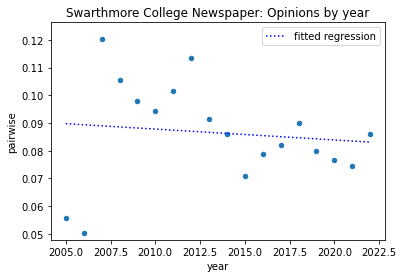

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Swarthmore College Phoenix: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.04165, int:0.13663, r:0.66729, p:0.00248, se:0.01162, x:range(0, 18)
pairwise slope:-0.00039, int:0.08975, r:-0.11581, p:0.64723, se:0.00084, x:range(0, 18)


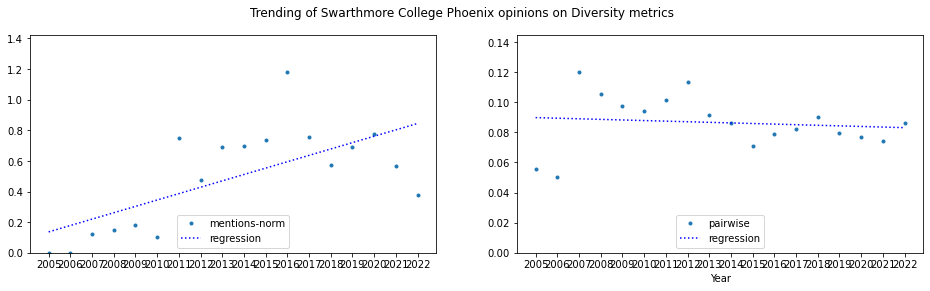

In [28]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
 
    # Add a title
    # ax.set_title(f"Trending of {column} in Liberty University's Champion")
    
plt.xlabel("Year")
plt.suptitle("Trending of Swarthmore College Phoenix opinions on Diversity metrics")
plt.show()